In [19]:
#This code is for the differentiating cell type example
#comparing matrix and hypermatrix methods
#striped 3-fold hypermatrix example

#This is an example comparison between symmetric tensor decomposition
#and matrix unfolding for this particular 3-fold tensor

In [2]:
#imports 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from tensorly.decomposition import non_negative_parafac
import tensorly as tl
from scipy.linalg import svd
from sklearn.manifold import TSNE
import textwrap
from matplotlib.colors import LinearSegmentedColormap
import h5py
from sklearn.decomposition import NMF
from numpy.linalg import svd
import scipy.io
import umap
import seaborn as sns
from scipy.stats import zscore
from tensorly import tensor as tl_tensor
import random
import scipy.io as sio
import pickle
import os

/home/dwk681/.conda/envs/multiomics6/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-16 09:02:05.433237: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-16 09:02:05.435692: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 09:02:05.491510: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 09:02:05.492863: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performanc

In [14]:
# Parameters
num_experiments = 2
num_categories = 10  #numner of cell types
num_samples = 200
num_genomic_bins = 210  
rank = 50           #rank of the decomposition
np.random.seed(2)

In [15]:
num_experiments

2

In [16]:
#skip down to loading the data if you already ran the below blocks

In [17]:
# Generate the experimental_vectors with random values between 0 and 1
experimental_vectors = np.hstack([np.random.rand(num_experiments, 1) for _ in range(num_categories)])

# Initialize the sample_vectors matrix
sample_vectors = np.ones((num_samples, num_categories)) 
bin_size = int(num_samples / num_categories)

# Fill in the sample_vectors matrix
for i in range(num_categories):
    start_index = i * bin_size
    end_index = start_index + bin_size
    sample_vectors[start_index:end_index, i] = 1.2

# Initialize the genomic_vectors matrix
centroids = np.random.randint(1, 3, (num_categories, num_genomic_bins))
genomic_vectors = centroids.T

# Make the synthetic tensor from the synthetic low rank factors
example_tensor = np.zeros((num_genomic_bins, num_genomic_bins, num_samples, num_experiments))

for i in range(num_categories):
    A = np.array(genomic_vectors[:, i])
    B = np.array(sample_vectors[:, i])
    C = np.array(experimental_vectors[:, i])
    product = np.tensordot(A, A, axes=0)
    product = np.tensordot(product, B, axes=0)
    product = np.tensordot(product, C, axes=0)
    example_tensor += product  # Accumulate the product

# Example tensor now contains contributions from all categories
example_tensor.shape

(210, 210, 200, 2)

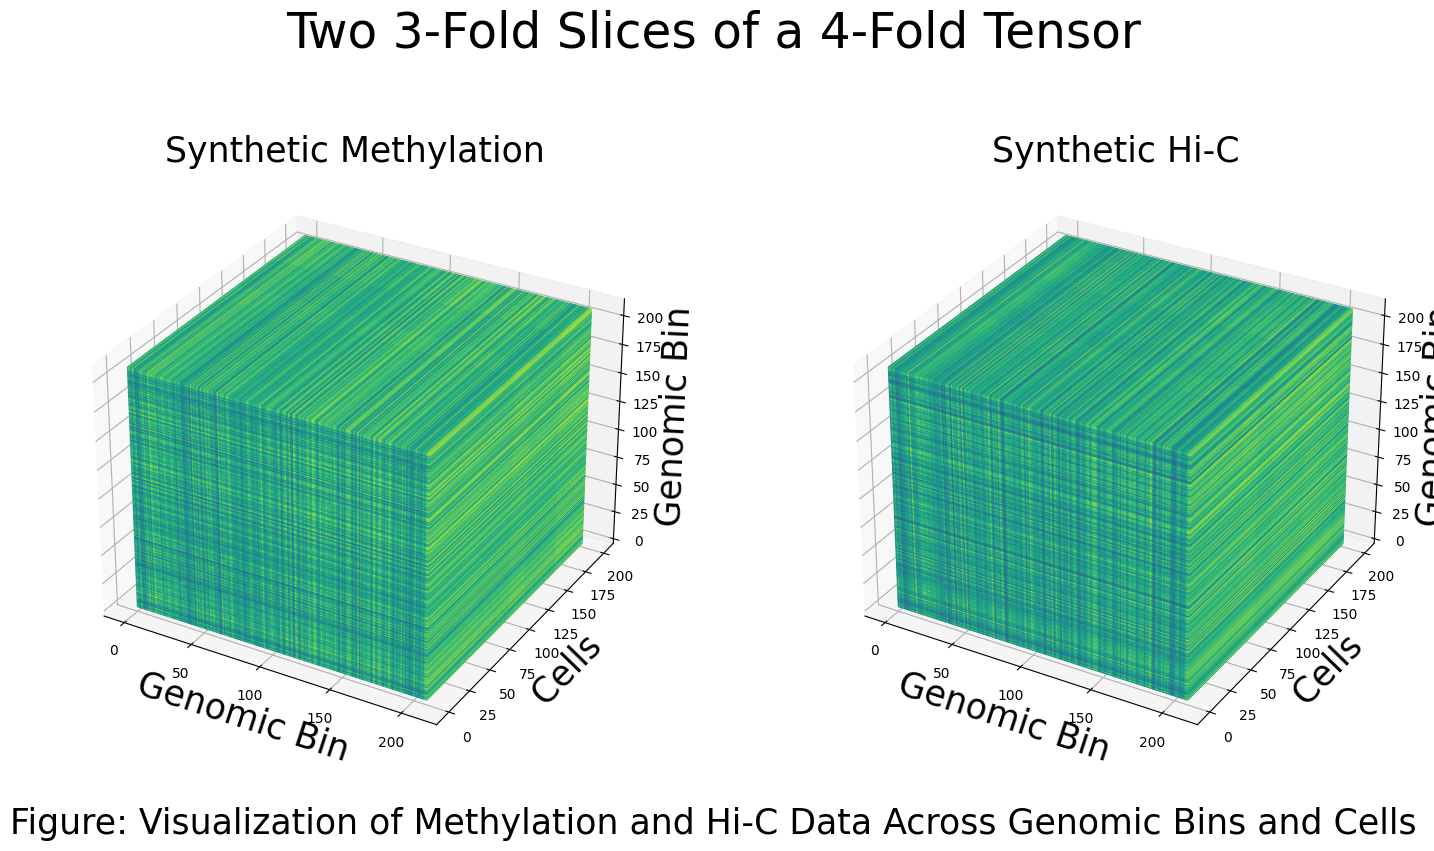

In [18]:
#Visualize the generated tensor to make sure it looks ok

fontsize1 = 35
fontsize2 = 25

def visualize_tensor_3d_different(tensor1, tensor2):
    fig = plt.figure(figsize=(18, 8))

    # First subplot for tensor1
    ax1 = fig.add_subplot(121, projection='3d')

    # Get tensor dimensions for tensor1
    num_slices1, nx1, ny1 = tensor1.shape

    # Adjust the distance between slices for better visualization
    z_spacing = 1  # Set the spacing between slices to 1 unit

    # Create a 3D image: each slice is placed at a different 'z'
    for i in range(num_slices1):
        x, y = np.meshgrid(range(nx1), range(ny1), indexing='ij')
        z = np.full_like(x, i * z_spacing)  # Set depth based on the slice index
        ax1.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.viridis(tensor1[i] / np.max(tensor1)), shade=False, alpha=0.7)
    
    ax1.set_xlabel('Genomic Bin', fontsize=fontsize2)
    ax1.set_ylabel('Cells', fontsize=fontsize2)
    ax1.set_zlabel('Genomic Bin', fontsize=fontsize2)
    ax1.set_zlim(0, num_slices1 * z_spacing)  # Set z-axis limit to number of slices times the spacing
    ax1.set_title('Synthetic Methylation', fontsize=fontsize2)

    # Second subplot for tensor2
    ax2 = fig.add_subplot(122, projection='3d')

    # Get tensor dimensions for tensor2
    num_slices2, nx2, ny2 = tensor2.shape

    # Create a 3D image: each slice is placed at a different 'z'
    for i in range(num_slices2):
        x, y = np.meshgrid(range(nx2), range(ny2), indexing='ij')
        z = np.full_like(x, i * z_spacing)  # Set depth based on the slice index
        ax2.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.viridis(tensor2[i] / np.max(tensor2)), shade=False, alpha=0.7)
    
    ax2.set_xlabel('Genomic Bin', fontsize=fontsize2)
    ax2.set_ylabel('Cells', fontsize=fontsize2)
    ax2.set_zlabel('Genomic Bin', fontsize=fontsize2)
    ax2.set_zlim(0, num_slices2 * z_spacing)  # Set z-axis limit to number of slices times the spacing
    ax2.set_title('Synthetic Hi-C', fontsize=fontsize2)

    plt.suptitle('Two 3-Fold Slices of a 4-Fold Tensor', fontsize=fontsize1, y=1.05)  # Adjust the 'y' parameter to add space
    fig.text(0.5, 0.02, 'Figure: Visualization of Methylation and Hi-C Data Across Genomic Bins and Cells', ha='center', fontsize=fontsize2)
    
    plt.subplots_adjust(top=0.85)  # Adjust the top parameter to add space for the title
    plt.show()

# Visualize the tensor slices
visualize_tensor_3d_different(example_tensor[:,:,:,0], example_tensor[:,:,:,1])


In [19]:
#Save a slice of the tensor
# Extract the specific tensor slice
tensor_slice = example_tensor[:,:,:,0]

# Creating the specified directory
directory_path = f'/home/dwk681/workspace/grant/examples/example_3fold_striped_{num_categories}_cell_types'
os.makedirs(directory_path, exist_ok=True)

# Save the tensor slice to a .mat file
sio.savemat(f'/home/dwk681/workspace/grant/examples/example_3fold_striped_{num_categories}_cell_types/tensor_slice.mat', {'tensor_slice': tensor_slice})

# Confirmation message
print(f"Tensor slice of size {example_tensor[:,:,:,0].shape} saved to 'tensor_slice.mat'")

Tensor slice of size (210, 210, 200) saved to 'tensor_slice.mat'


In [20]:
#Save the four fold tensor as well

# Creating the specified directory
directory_path = f'/home/dwk681/workspace/grant/examples/example_4fold_striped_{num_categories}_cell_types'
os.makedirs(directory_path, exist_ok=True)

# Save the tensor slice to a .mat file
sio.savemat(f'/home/dwk681/workspace/grant/examples/example_4fold_striped_{num_categories}_cell_types/tensor.mat', {'tensor': example_tensor})

# Confirmation message
print(f"Tensor slice of size {example_tensor.shape} saved to 'tensor.mat'")

Tensor slice of size (210, 210, 200, 2) saved to 'tensor.mat'


In [21]:
#The symmetric decomposition is done in MATLAB

# Define the SLURM script content
script_content = f"""#!/bin/bash

#SBATCH --account=b1042
#SBATCH --partition=genomics
#SBATCH --time=5:00:00
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=5
#SBATCH --mem=150G
#SBATCH --error=/home/dwk681/workspace/grant/logs/%JgetStructuredDataLog.err
#SBATCH --output=/home/dwk681/workspace/grant/logs/%JgetStructuredDataLog.out

# Load the necessary modules for conda
source /etc/profile
source ~/.bashrc

# Activate the conda environment
conda activate multiomics6

module load matlab/r2022b

# Set the path for data storage
data_path="/home/dwk681/workspace/grant/examples/example_3fold_striped_{num_categories}_cell_types"

# Start of MATLAB code
matlab -nodisplay -nosplash << MATLAB_SCRIPT
% MATLAB code here
path = '$data_path';

addpath(genpath('/home/dwk681/workspace/softwareFiles/tensorlab'));

% Load the .mat file
data = load(fullfile(path, 'tensor_slice.mat'));

% Access the tensor slice
tensor_slice = data.tensor_slice;

% Display the size of the tensor slice
disp(size(tensor_slice));

r = {rank};
s = {num_genomic_bins};
sol_factors = cell(1, r);

n = size(tensor_slice, 1);
m = size(tensor_slice, 3);
"""+"""
model = struct;
model.variables.u = rand(n, r);
model.variables.w = rand(m, r);
model.factors.U = {'u', @struct_nonneg};
model.factors.W = {'w', @struct_nonneg}; 
model.factorizations.myfac.data = tensor_slice;
model.factorizations.myfac.cpd = {'U', 'U', 'W'};
options.Display = 100;
options.MaxIter = 400;
sol = sdf_nls(model, options);
sol_factors{1, 1} = {sol.factors.U, sol.factors.W};

% Save the processed data
output_file = fullfile(path, sprintf('stripe_tensor_400iterations_rank%d_symmetry_%d_by_%d.mat', r, s, s));

save(output_file, 'sol_factors');

MATLAB_SCRIPT
"""

# Path to the SLURM script
script_path = f"/home/dwk681/workspace/grant/examples/example_3fold_striped_{num_categories}_cell_types/run_tensor_job.sh"

# Write the SLURM script to a file
with open(script_path, "w") as file:
    file.write(script_content)

# Make the script executable
!chmod +x {script_path}

# Submit the SLURM script
!sbatch {script_path}


Submitted batch job 5777024


In [22]:
# Load the tensor slice in case it is no longer in your workspace
mat_contents = sio.loadmat(f'/home/dwk681/workspace/grant/examples/example_3fold_striped_{num_categories}_cell_types/tensor_slice.mat')

# Extract the tensor slice
tensor_slice = mat_contents['tensor_slice']

# Confirmation message
print(f"Tensor slice of size {tensor_slice.shape} loaded from 'tensor_slice.mat'")

Tensor slice of size (210, 210, 200) loaded from 'tensor_slice.mat'


In [ ]:
import time

# Wait for 10 seconds
#may need to wait longer, depending on how fast the job is taken up
time.sleep(10)

print("Waited for 10 seconds")

In [23]:
# Load the .mat file containing the low-rank factors
# After the tensor decomposition is completed in MATLAB
data = sio.loadmat(f'/home/dwk681/workspace/grant/examples/example_3fold_striped_{num_categories}_cell_types/stripe_tensor_400iterations_rank{rank}_symmetry_{num_genomic_bins}_by_{num_genomic_bins}.mat')

# Extract the factors from the loaded data
sol_factors = data['sol_factors']

genomic_factors = sol_factors[0][0][0][0]  
sample_factors = sol_factors[0][0][0][1]  

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_result = tsne.fit_transform(sample_factors)  


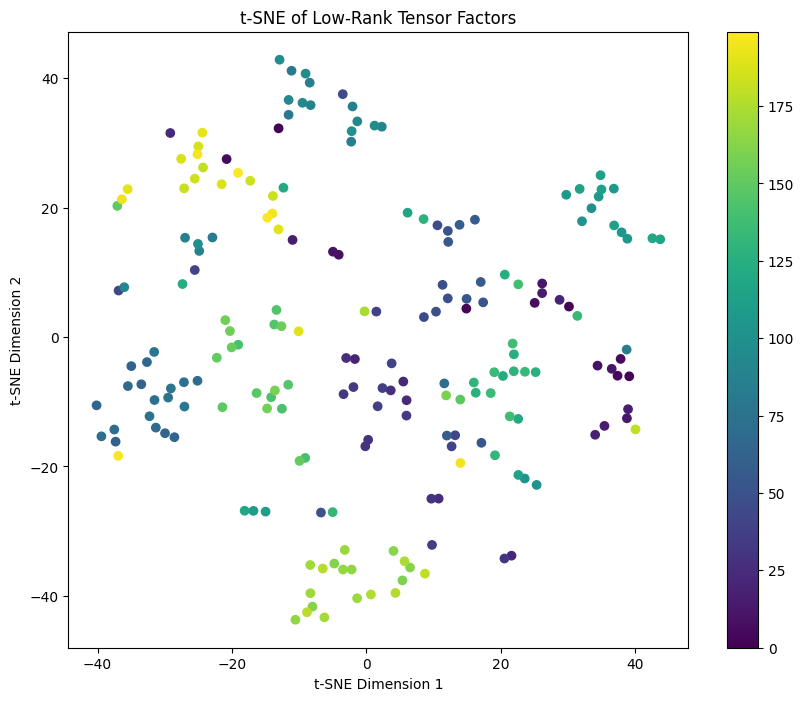

In [25]:
# Plot the t-SNE result to make sure everything looks ok
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=np.arange(sample_factors.shape[0]), cmap='viridis')
plt.title('t-SNE of Low-Rank Tensor Factors')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()


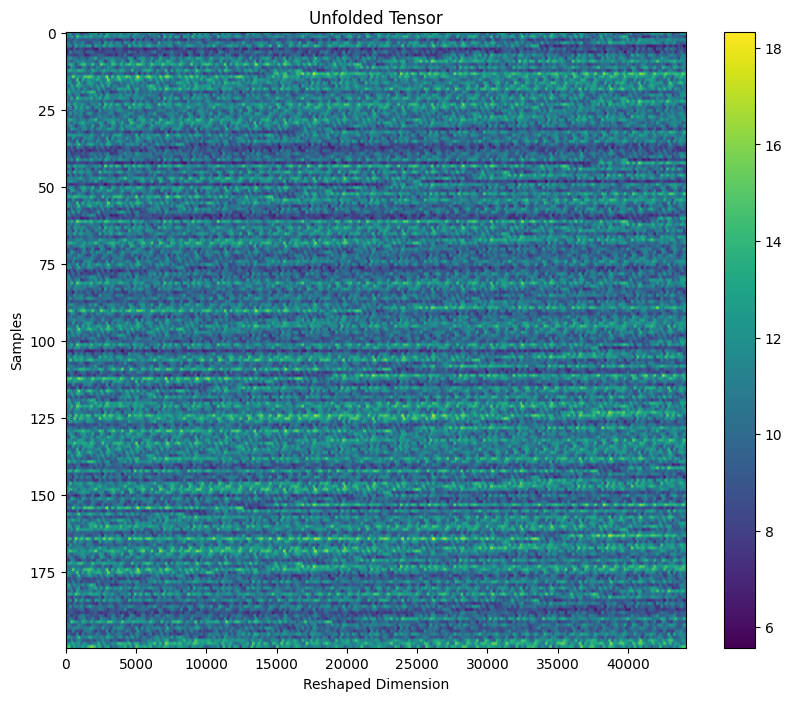

In [26]:
# Unfold the tensor from shape (100, 100, 60) to (60, 100*100)
unfolded_matrix = np.reshape(tensor_slice, (tensor_slice.shape[2], -1))

# Visualize the unfolded matrix
plt.figure(figsize=(10, 8))
plt.imshow(unfolded_matrix, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Unfolded Tensor')
plt.xlabel('Reshaped Dimension')
plt.ylabel('Samples')
plt.show()

/home/dwk681/.conda/envs/multiomics6/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


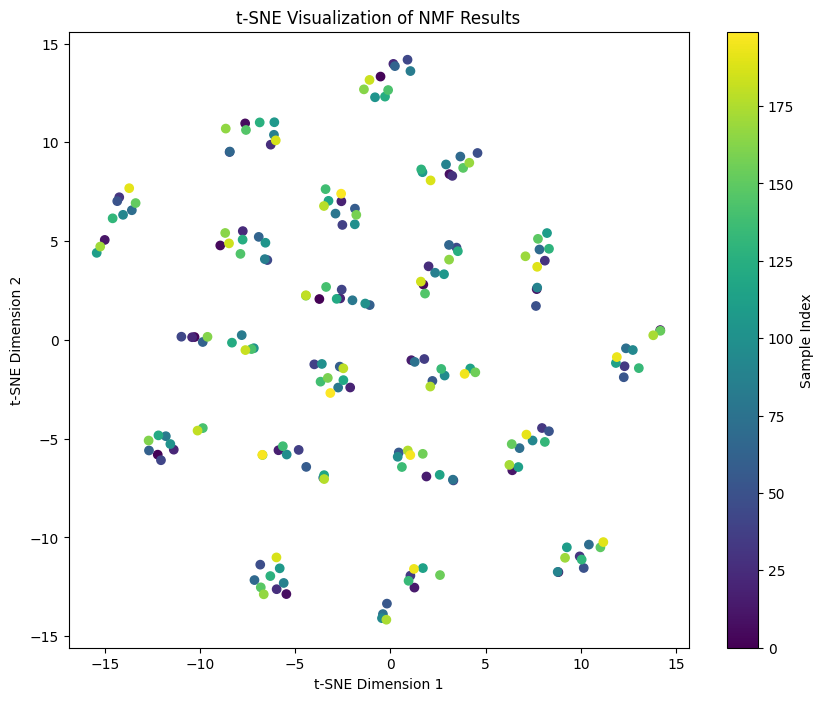

In [27]:
# Perform low-rank non-negative matrix factorization (NMF)

nmf_model = NMF(n_components=rank, init='random', random_state=0, max_iter=400)
W = nmf_model.fit_transform(unfolded_matrix)
H = nmf_model.components_

# Apply t-SNE to the NMF results
tsne_model_matrix = TSNE(n_components=2, random_state=0)
tsne_results_matrix = tsne_model_matrix.fit_transform(W)

# Visualize the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results_matrix[:, 0], tsne_results_matrix[:, 1], c=np.arange(W.shape[0]), cmap='viridis')
plt.colorbar(label='Sample Index')
plt.title('t-SNE Visualization of NMF Results')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [28]:
# Create a dictionary with all the variables you want to save
variables_dict = {
    'num_experiments': num_experiments,
    'num_categories': num_categories,
    'num_samples': num_samples,
    'num_genomic_bins': num_genomic_bins,
    'experimental_vectors': experimental_vectors,
    'sample_vectors': sample_vectors,
    'genomic_vectors': genomic_vectors,
    'example_tensor': example_tensor,
    'sol_factors': sol_factors,
    'genomic_factors': genomic_factors,
    'sample_factors': sample_factors,
    'tsne_result': tsne_result,
    'W': W,
    'H': H,
    'tsne_results_matrix': tsne_results_matrix,
    'unfolded_matrix': unfolded_matrix,
    'tensor_slice': tensor_slice,
    'rank': rank
}

# Save the dictionary to a file
with open(f'/home/dwk681/workspace/grant/examples/example_3fold_striped_{num_categories}_cell_types/example_environment_variables.pkl', 'wb') as file:
    pickle.dump(variables_dict, file)

print("All variables have been saved to 'example_environment_variables.pkl'")


All variables have been saved to 'example_environment_variables.pkl'


In [29]:
#load the saved variables if not already in your enviroment

with open(f'/home/dwk681/workspace/grant/examples/example_3fold_striped_{num_categories}_cell_types/example_environment_variables.pkl', 'rb') as file:
    loaded_variables = pickle.load(file)

# Access the variables
num_experiments = loaded_variables['num_experiments']
num_categories = loaded_variables['num_categories']
num_samples = loaded_variables['num_samples']
num_genomic_bins = loaded_variables['num_genomic_bins']
experimental_vectors = loaded_variables['experimental_vectors']
sample_vectors = loaded_variables['sample_vectors']
genomic_vectors = loaded_variables['genomic_vectors']
example_tensor = loaded_variables['example_tensor']
sol_factors = loaded_variables['sol_factors']
genomic_factors = loaded_variables['genomic_factors']
sample_factors = loaded_variables['sample_factors']
tsne_result = loaded_variables['tsne_result']
W = loaded_variables['W']
H = loaded_variables['H']
tsne_results_matrix = loaded_variables['tsne_results_matrix']
unfolded_matrix = loaded_variables['unfolded_matrix']
tensor_slice = loaded_variables['tensor_slice']
rank = loaded_variables['rank']

print("All variables have been loaded from 'example_environment_variables.pkl'")

#also load the 4fold tensor

# Load the tensor from the .mat file
file_path = '/home/dwk681/workspace/grant/examples/example_4fold_striped_40_cell_types/tensor.mat'
loaded_data = sio.loadmat(file_path)

# Extract the tensor
tensor = loaded_data['tensor']

print(tensor.shape)

All variables have been loaded from 'example_environment_variables.pkl'
(210, 210, 200, 2)


In [30]:
#Now, we proceed with the 4fold example simulation
#The symmetric decomposition is done in MATLAB

# Define the SLURM script content
script_content = f"""#!/bin/bash

#SBATCH --account=b1042
#SBATCH --partition=genomics
#SBATCH --time=5:00:00
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=5
#SBATCH --mem=150G
#SBATCH --error=/home/dwk681/workspace/grant/logs/%JgetStructuredDataLog.err
#SBATCH --output=/home/dwk681/workspace/grant/logs/%JgetStructuredDataLog.out

# Load the necessary modules for conda
source /etc/profile
source ~/.bashrc

# Activate the conda environment
conda activate multiomics6

module load matlab/r2022b

# Set the path for data storage
data_path="/home/dwk681/workspace/grant/examples/example_4fold_striped_{num_categories}_cell_types"

# Start of MATLAB code
matlab -nodisplay -nosplash << MATLAB_SCRIPT
% MATLAB code here
path = '$data_path';

addpath(genpath('/home/dwk681/workspace/softwareFiles/tensorlab'));

% Load the .mat file
data = load(fullfile(path, 'tensor.mat'));

% Access the tensor slice
tensor = data.tensor;

% Display the size of the tensor
disp(size(tensor));

r = {rank};
s = {num_genomic_bins};
sol_factors = cell(1, r);

n = size(tensor, 1);
m = size(tensor, 3);
p = size(tensor, 4);

"""+"""
model = struct;
model.variables.u = rand(n, r);
model.variables.w = rand(m, r);
model.variables.v = rand(p, r);
model.factors.U = {'u', @struct_nonneg};
model.factors.W = {'w', @struct_nonneg}; 
model.factors.V = {'v', @struct_nonneg}; 
model.factorizations.myfac.data = tensor;
model.factorizations.myfac.cpd = {'U', 'U', 'W', 'V'};
options.Display = 100;
options.MaxIter = 400;
sol = sdf_nls(model, options);
sol_factors{1, 1} = {sol.factors.U, sol.factors.W, sol.factors.V};

% Save the processed data
output_file = fullfile(path, sprintf('stripe_tensor_400iterations_rank%d_symmetry_%d_by_%d_by_%d.mat', r, s, s, p));

save(output_file, 'sol_factors');

MATLAB_SCRIPT
"""

# Path to the SLURM script
script_path = f"/home/dwk681/workspace/grant/examples/example_4fold_striped_{num_categories}_cell_types/run_tensor_job.sh"

# Write the SLURM script to a file
with open(script_path, "w") as file:
    file.write(script_content)

# Make the script executable
!chmod +x {script_path}

# Submit the SLURM script
!sbatch {script_path}


Submitted batch job 5789249


In [31]:
tensor.shape

(210, 210, 200, 2)

In [28]:
# Load the .mat file containing the low-rank factors
# After the tensor decomposition is completed in MATLAB
data = sio.loadmat(f'/home/dwk681/workspace/grant/examples/example_4fold_striped_{num_categories}_cell_types/stripe_tensor_400iterations_rank{rank}_symmetry_{num_genomic_bins}_by_{num_genomic_bins}_by_{num_experiments}.mat')

# Extract the factors from the loaded data
sol_factors = data['sol_factors']

genomic_factors_4fold = sol_factors[0][0][0][0]  
sample_factors_4fold = sol_factors[0][0][0][1]  
experimental_factors_4fold = sol_factors[0][0][0][2]  

# Perform t-SNE
tsne_4fold = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_result_4fold = tsne_4fold.fit_transform(sample_factors_4fold)  


print(f' drata processed form /home/dwk681/workspace/grant/examples/example_4fold_striped_{num_categories}_cell_types/stripe_tensor_400iterations_rank{rank}_symmetry_{num_genomic_bins}_by_{num_genomic_bins}_by_{num_experiments}.mat')

 drata processed form /home/dwk681/workspace/grant/examples/example_4fold_striped_40_cell_types/stripe_tensor_400iterations_rank50_symmetry_210_by_210_by_3.mat


In [34]:
tsne_result_4fold.shape

(200, 2)

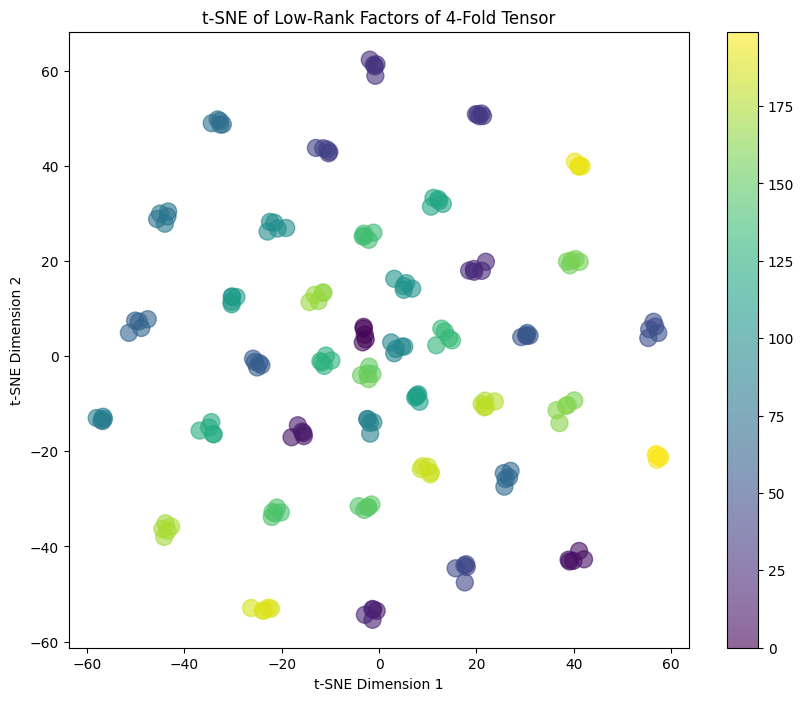

In [46]:
#log_tsne_result_4fold = np.log1p(tsne_result_4fold + 100)

jitter_strength = 1  # Adjust the jitter strength as needed
jittered_tsne_result = tsne_result_4fold + np.random.normal(scale=jitter_strength, size=tsne_result_4fold.shape)

# Plot the t-SNE result to make sure everything looks ok
plt.figure(figsize=(10, 8))
plt.scatter(jittered_tsne_result[:, 0], jittered_tsne_result[:, 1], c=np.arange(sample_factors.shape[0]), cmap='viridis', s=150, alpha=0.6)
plt.title('t-SNE of Low-Rank Factors of 4-Fold Tensor')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()


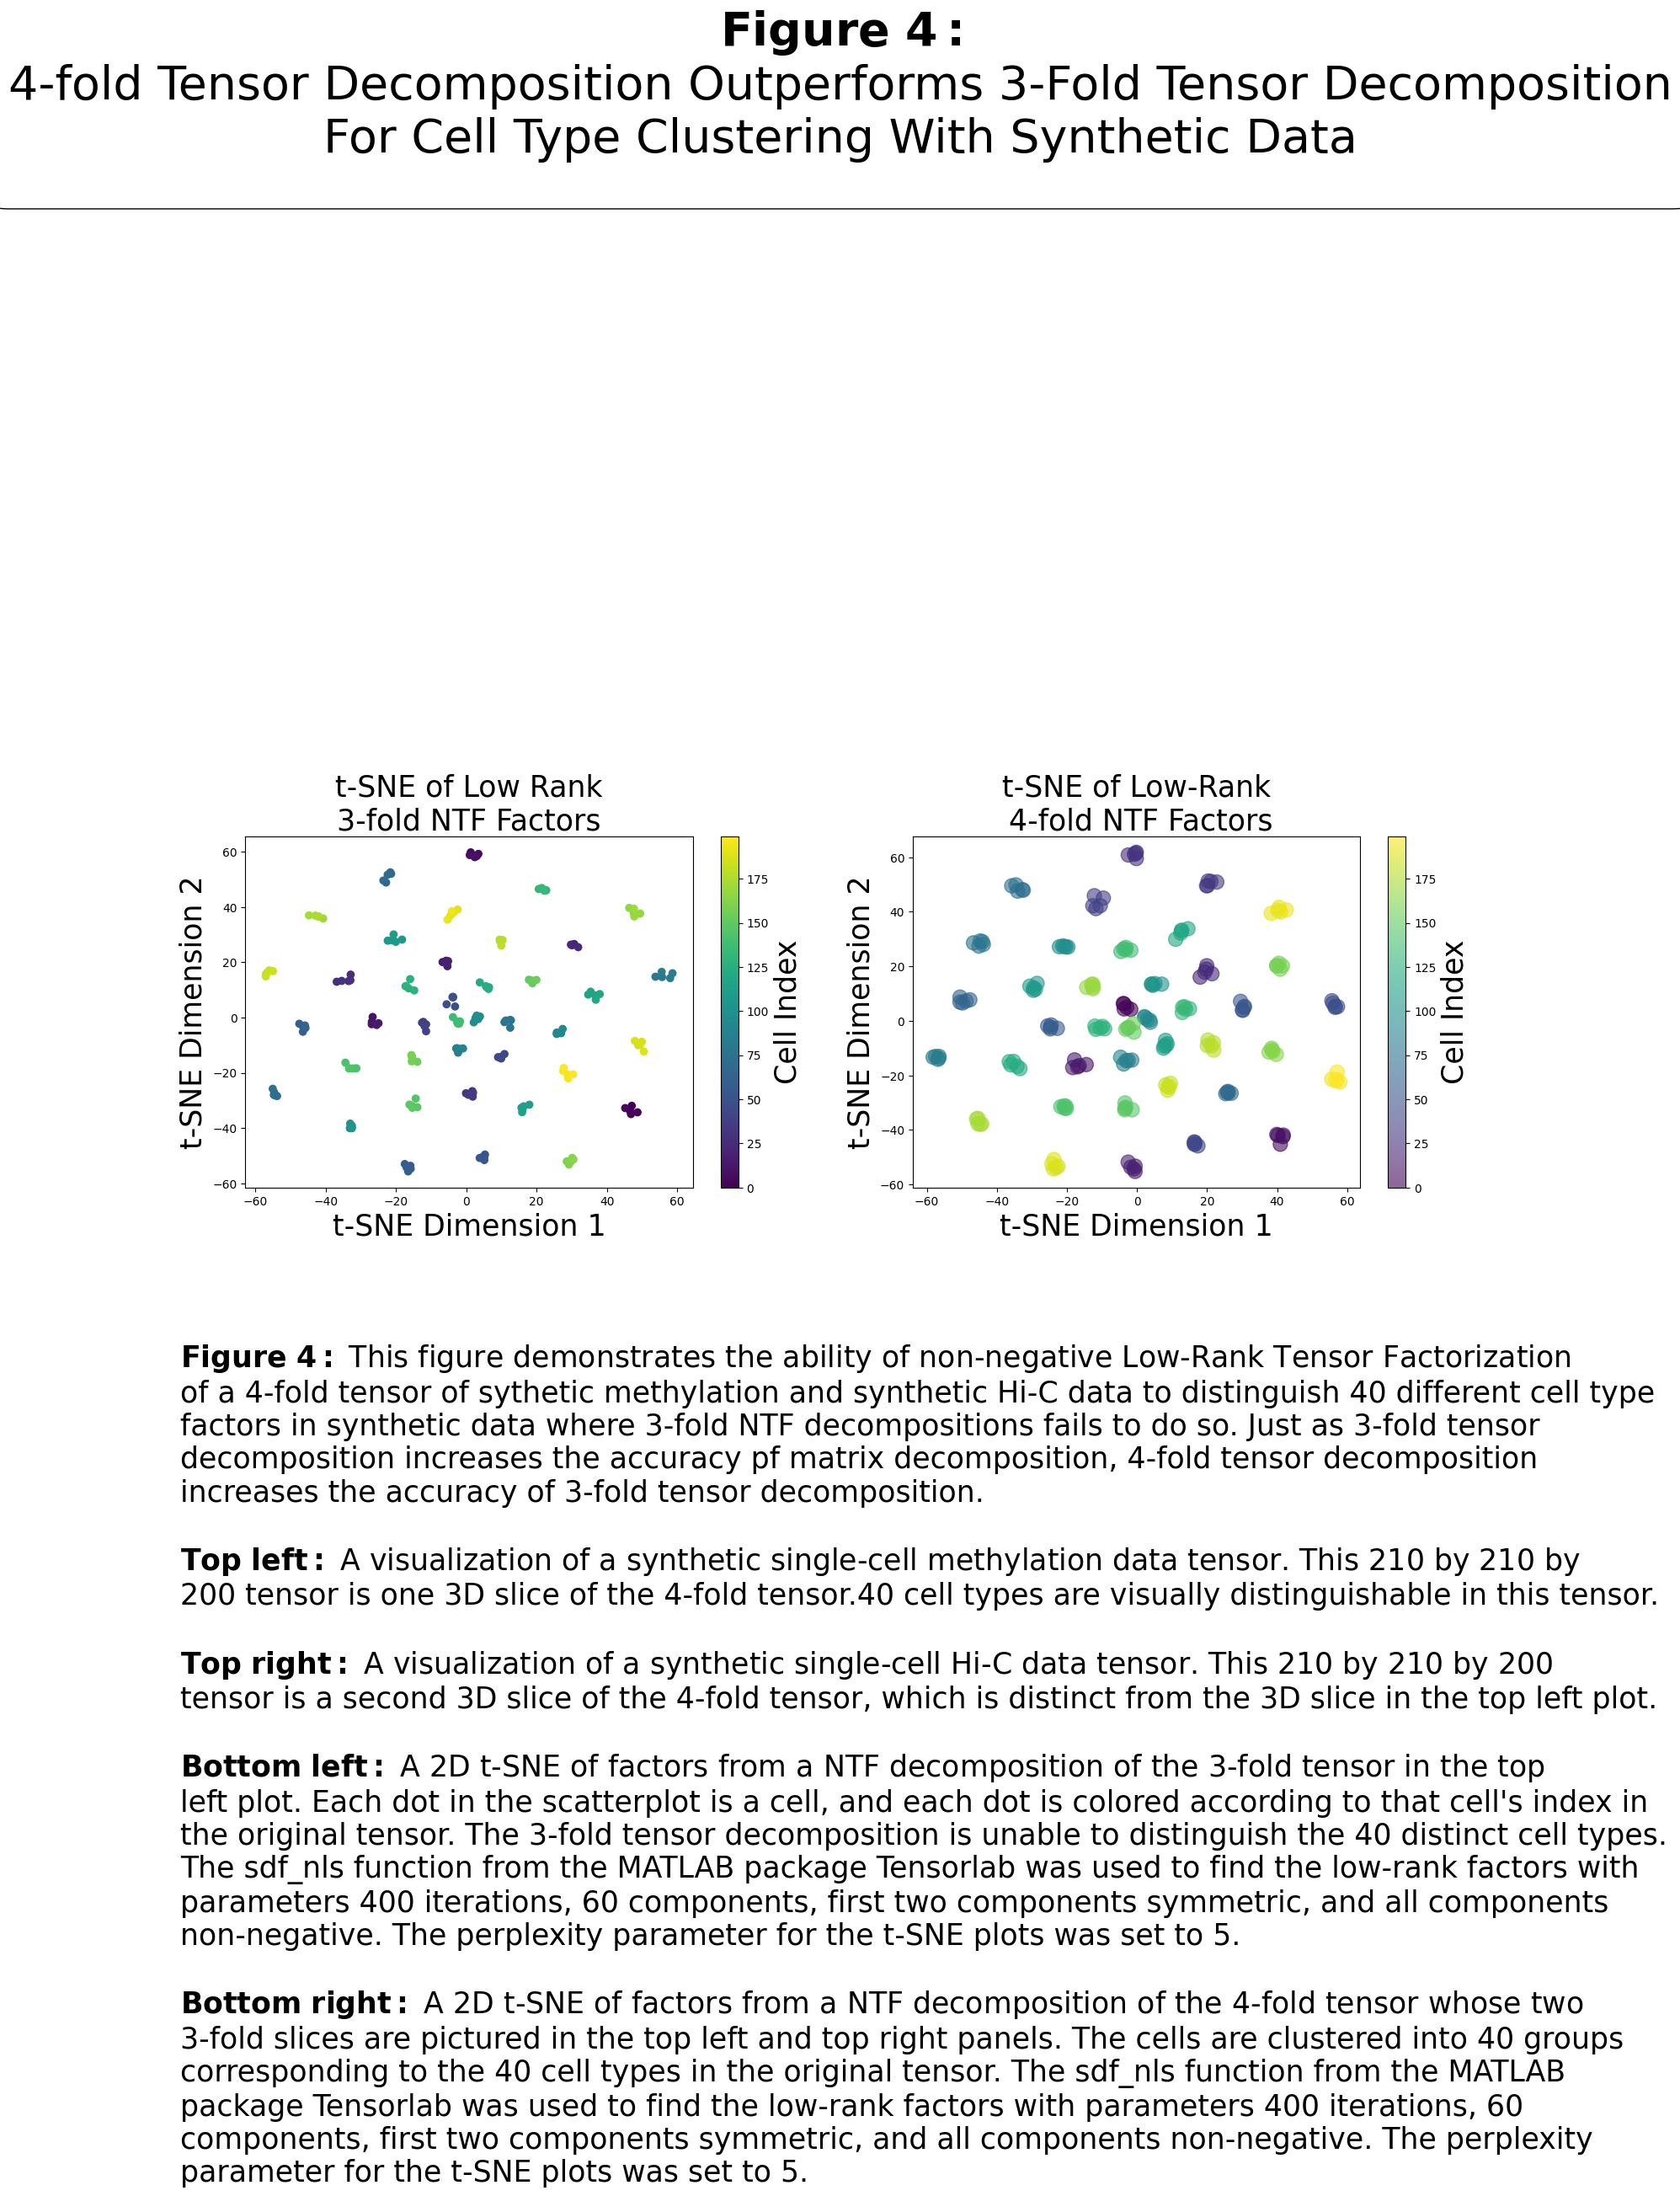

In [53]:
#make the image demonstrating the example

#set sizes for title font and subfonts
fontsize1 = 35
fontsize2 = 25

# Create a figure with four plots
fig = plt.figure(figsize=(16, 25))

# # Plot 1: Synthetic Methylation Tensor Visualization (3D Plot)
# ax1 = fig.add_subplot(221, projection='3d')
# # Flip tensor so "Cells" is on the x-axis
# tensor1_flipped = np.transpose(tensor_slice, (1, 2, 0))
# num_slices1, nx1, ny1 = tensor1_flipped.shape
# z_spacing = 1  # Set the spacing between slices to 1 unit
# for i in range(num_slices1):
#     x, y = np.meshgrid(range(nx1), range(ny1), indexing='ij')
#     z = np.full_like(x, i * z_spacing)  # Set depth based on the slice index
#     ax1.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.viridis(tensor1_flipped[i] / np.max(tensor1_flipped)), shade=False, alpha=0.7)
# ax1.set_xlabel('Cells', fontsize=fontsize2)
# ax1.set_ylabel('Genomic Bin', fontsize=fontsize2 - 5)
# ax1.set_zlabel('Genomic Bin', fontsize=fontsize2 - 5)
# ax1.set_zlim(0, num_slices1 * z_spacing)  # Set z-axis limit to number of slices times the spacing
# ax1.set_title('Synthetic\nMethylation Data', fontsize=fontsize2)

# # Plot 2: Synthetic Hi-C Tensor Visualization (3D Plot)
# ax2 = fig.add_subplot(221, projection='3d')
# # Flip tensor so "Cells" is on the x-axis
# tensor1_flipped_2 = np.transpose( example_tensor[:,:,:,1], (1, 2, 0))
# num_slices1, nx1, ny1 = tensor1_flipped_2.shape
# z_spacing = 1  # Set the spacing between slices to 1 unit
# for i in range(num_slices1):
#     x, y = np.meshgrid(range(nx1), range(ny1), indexing='ij')
#     z = np.full_like(x, i * z_spacing)  # Set depth based on the slice index
#     ax2.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.viridis(tensor1_flipped_2[i] / np.max(tensor1_flipped_2)), shade=False, alpha=0.7)
# ax2.set_xlabel('Cells', fontsize=fontsize2)
# ax2.set_ylabel('Genomic Bin', fontsize=fontsize2 - 5)
# ax2.set_zlabel('Genomic Bin', fontsize=fontsize2 - 5)
# ax2.set_zlim(0, num_slices1 * z_spacing)  # Set z-axis limit to number of slices times the spacing
# ax2.set_title('Synthetic\nHi-C Data', fontsize=fontsize2)

# Plot 3: t-SNE of 3-fold NTF Results
ax3 = fig.add_subplot(223)
jitter_strength = 1  # Add jitter so that all dots are not on top of each other
jittered_tsne_result = tsne_result + np.random.normal(scale=jitter_strength, size=tsne_result_4fold.shape)
scatter2 = ax3.scatter(jittered_tsne_result[:, 0], jittered_tsne_result[:, 1], c=np.arange(W.shape[0]), cmap='viridis')
ax3.set_title('t-SNE of Low Rank\n3-fold NTF Factors', fontsize=fontsize2)
ax3.set_xlabel('t-SNE Dimension 1', fontsize=fontsize2)
ax3.set_ylabel('t-SNE Dimension 2', fontsize=fontsize2)
cbar2 = plt.colorbar(scatter2, ax=ax3)
cbar2.set_label('Cell Index', fontsize=fontsize2)

# Plot 4: t-SNE of 4-fold NTF Results
ax4 = fig.add_subplot(224)
jitter_strength = 1  # Add jitter so that all dots are not on top of each other
jittered_tsne_result_4fold = tsne_result_4fold + np.random.normal(scale=jitter_strength, size=tsne_result_4fold.shape)
scatter = ax4.scatter(jittered_tsne_result_4fold[:, 0], jittered_tsne_result_4fold[:, 1], c=np.arange(sample_factors.shape[0]), cmap='viridis', s=150, alpha=0.6)
ax4.set_title('t-SNE of Low-Rank\n 4-fold NTF Factors', fontsize=fontsize2)
ax4.set_xlabel('t-SNE Dimension 1', fontsize=fontsize2)
ax4.set_ylabel('t-SNE Dimension 2', fontsize=fontsize2)
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Cell Index', fontsize=fontsize2)

#fig.suptitle(f'Figure 2\nComparison of Tensor and Matrix Methods\nSynthetic Data With Six Cell Types', fontsize=fontsize1, y=0.98, weight='bold')
#plt.suptitle(r"$\bf{Visualization\ of\ Tensor\ and\ Matrix\ Decompositions}$" + "\n" + r"$\bf{Synthetic\ Data\ With\ Six\ Cell\ Types}$", fontsize=fontsize1, y=0.98, multialignment='center')
plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom = .48, hspace=0.4)  

# Add a caption
caption = (
    r"$\bf{Figure \ 4:}$ This figure demonstrates the ability of non-negative Low-Rank Tensor Factorization of a "
    f"4-fold tensor of sythetic methylation and synthetic Hi-C data to distinguish {num_categories} different cell "
    f"type factors in synthetic data where 3-fold NTF decompositions fails to do so. Just as 3-fold tensor "
    f"decomposition increases the accuracy pf matrix decomposition, 4-fold tensor decomposition increases the "
    f"accuracy of 3-fold tensor decomposition. "
    "\n\n"
    r"$\bf{Top \ left:}$ A visualization of a synthetic single-cell methylation data tensor. "
    f"This {num_genomic_bins} by {num_genomic_bins} by {num_samples} tensor is one 3D slice of the 4-fold tensor."
    f"{num_categories} cell types are visually distinguishable in this tensor. "
    "\n\n"
    r"$\bf{Top \ right:}$ A visualization of a synthetic single-cell Hi-C data tensor. "
    f"This {num_genomic_bins} by {num_genomic_bins} by {num_samples} tensor is a second 3D slice of the 4-fold tensor, "
    f"which is distinct from the 3D slice in the top left plot. "
    "\n\n"
    r"$\bf{Bottom \ left:}$ A 2D t-SNE of factors from a NTF decomposition of the 3-fold tensor in the top left plot. "
    f"Each dot in the scatterplot is a cell, and each dot is colored according to that cell's index in the original tensor. "
    f"The 3-fold tensor decomposition is unable to distinguish the {num_categories} distinct cell types. "
    f"The sdf_nls function from the MATLAB package Tensorlab was used to find the low-rank factors with parameters "
    f"400 iterations, 60 components, first two components symmetric, and all components non-negative. "
    f"The perplexity parameter for the t-SNE plots was set to 5."    
    "\n\n"
    r"$\bf{Bottom \ right:}$ A 2D t-SNE of factors from a NTF decomposition of the 4-fold tensor whose two "
    f"3-fold slices are pictured in the top left and top right panels. "
    f"The cells are clustered into {num_categories} groups corresponding to the {num_categories} cell types in the original tensor. "
    f"The sdf_nls function from the MATLAB package Tensorlab was used to find the low-rank factors with parameters "
    f"400 iterations, 60 components, first two components symmetric, and all components non-negative. "
    f"The perplexity parameter for the t-SNE plots was set to 5."
)

fig.text(0.01, 0.01, caption, ha='left', fontsize=fontsize2, wrap=True)

# Add a single frame around the title and subtitle
fig.text(0.5, 1.04, r"$\bf{Figure \ 4:}$"+f"\n4-fold Tensor Decomposition Outperforms 3-Fold Tensor Decomposition\nFor Cell Type Clustering With Synthetic Data",
         ha='center', va='top', fontsize=40, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=1.0"))



plt.show()

In [25]:
!python --version

Python 2.7.5
